## Scraping

In [93]:
!pip install isodate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00


In [127]:
!pip install WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser

In [ ]:
from IPython.display import JSON

In [ ]:
api_key = ""

[references](https://developers.google.com/youtube/v3/docs)

In [ ]:
youtube = build("youtube", "v3", developerKey=api_key)

to get chanel id - [link](https://commentpicker.com/youtube-channel-id.php)

In [ ]:
"https://commentpicker.com/youtube-channel-id.php"

#AMV - ORG > https://www.youtube.com/@AMVNewsChronicles
#AMV - HELL > https://www.youtube.com/@amvhell

channel_ids = ['UCLfk6sq06Nqh2gNS_1Ztv4Q', 'UCcsGSCt3H94_89mT1HDyv0g']

In [ ]:
request = youtube.channels().list(    
        part= "snippet, contentDetails, statistics",
        id=','.join(channel_ids)
    )
response = request.execute()

In [58]:
JSON(response['items'])

<IPython.core.display.JSON object>

In [59]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(
                    channelName = response['items'][i]['snippet']['title'],
                    channelDescription = response['items'][i]['snippet']['description'],
            
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
            
                    playlistID = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'],
                    channelID = response['items'][i]['id']
                    
                    )
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [60]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [61]:
channel_stats

,channelName,channelDescription,subscribers,views,totalVideos,playlistID,channelID
0,amvhell,Please see our website at http://www.amvhell.c...,24300,5263266,68,UULfk6sq06Nqh2gNS_1Ztv4Q,UCLfk6sq06Nqh2gNS_1Ztv4Q
1,AMV News Chronicles,AMVNews.ru is a daily source for handpicked an...,3050,1035039,842,UUcsGSCt3H94_89mT1HDyv0g,UCcsGSCt3H94_89mT1HDyv0g


In [62]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part= "snippet, contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part= 'snippet, contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [63]:
channel_stats['playlistID']

0    UULfk6sq06Nqh2gNS_1Ztv4Q
1    UUcsGSCt3H94_89mT1HDyv0g
Name: playlistID, dtype: object

## Video Ifo

In [64]:
# Get video IDs
HELL_vid_id = get_video_ids(youtube, playlist_id = 'UULfk6sq06Nqh2gNS_1Ztv4Q')
ORG_vid_id  = get_video_ids(youtube, playlist_id = 'UUcsGSCt3H94_89mT1HDyv0g')

In [65]:
print(len(HELL_vid_id), len(ORG_vid_id))

68 836


In [66]:
JSON(response)

<IPython.core.display.JSON object>

In [67]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
        
        return(pd.DataFrame(all_video_info))


In [68]:
HELL_vid_info = get_video_details(youtube, HELL_vid_id)
ORG_vid_info  = get_video_details(youtube, ORG_vid_id)

In [69]:
HELL_vid_info.head(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Mwul17m-tCY,amvhell,AMV Hell 8 Teaser Trailer,Rules and submission info has been posted at h...,None,2023-04-21T01:02:22Z,9427,1212,None,435,PT1M12S,hd,false
1,cCI1owQ7CXI,amvhell,AMV Hell 1,The original AMV Hell,[amv hell],2019-09-30T00:44:43Z,76440,2004,None,381,PT5M18S,sd,false
2,vhreJ5xV_Z4,amvhell,AMV Minis Challenge - Final Destination,The true final episode of AMV Minis Challenge....,"[amv hell, AMV Minis, Challenge, anime, amv, a...",2015-01-24T18:26:20Z,49490,687,None,184,PT14M22S,hd,false


In [70]:
ORG_vid_info.head(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,OOMcKd4qfCo,AMV News Chronicles,AMV - ♪ Contemporary Dog ♪ - by Hikikomori,Info & DLL: https://amvnews.ru/index.php?go=Fi...,[AMV],2022-03-19T16:51:52Z,1586,72,None,4,PT3M47S,hd,false
1,O421QP_UkAc,AMV News Chronicles,Mix AMV - ♪ Clear sound ♪ - by espada98,Info & DLL: https://amvnews.ru/index.php?go=Fi...,[AMV],2022-03-11T19:05:52Z,937,37,None,3,PT2M53S,hd,false
2,Y7-t7QTgQws,AMV News Chronicles,Genshin Impact GMV - ♪ Impact ♪ - by Chiikaboom,Info & DLL: https://amvnews.ru/index.php?go=Fi...,[AMV],2021-11-17T21:14:51Z,1025,41,None,3,PT2M1S,hd,false


## Vid comments

In [71]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [72]:
HELL_vids_comments = get_comments_in_videos(youtube, HELL_vid_id)
ORG_vids_comments  = get_comments_in_videos(youtube, ORG_vid_id)

Could not get comments for video 1LnEuc4N8YE
Could not get comments for video m4Jxv5RyKIc
Could not get comments for video oH9jCqS7aCQ


In [74]:
#HELL_vids_comments[1]

In [73]:
HELL_vids_comments.to_csv("hell_vids_comments.csv")
ORG_vids_comments.to_csv("org_vids_comments.csv")

In [75]:
HELL_vids_comments.head()

,video_id,comments
0,Mwul17m-tCY,[I didn't realize this continued after AMV hel...
1,cCI1owQ7CXI,[Ah yes this truly takes me back to the good o...
2,vhreJ5xV_Z4,[AMV hell is the last thing what keeps my sani...
3,1_NwJtbJ8Rc,[What is this Animaniacs? It’s too meta. I lov...
4,fZDdsnzmRPs,"[11 is both more funny, and less funny this ye..."


In [78]:
ORG_vids_comments.head(3)

,video_id,comments
0,OOMcKd4qfCo,"[Хорошая подача,сюжет интересный), Недооцененн..."
1,O421QP_UkAc,"[давно не было, Great work! Keep it up What do..."
2,Y7-t7QTgQws,"[Hola porque no ases mas videos?!, These are r..."


### Analysis Ideas ###

    [ ] What are the average views per video?
    [ ] Do numbers of likes and comments matter for views?
    [ ] What kind of interactions?
    [ ] What are the subjects and discourses of the videos?
    [ ] Schedul a periodice of video uploding

## Data pre-processing

In [ ]:
#HELL_vid_info.
#ORG_vid_info.

In [97]:
ORG_vid_info.head(2)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,OOMcKd4qfCo,AMV News Chronicles,AMV - ♪ Contemporary Dog ♪ - by Hikikomori,Info & DLL: https://amvnews.ru/index.php?go=Fi...,[AMV],2022-03-19T16:51:52Z,1586,72,None,4,PT3M47S,hd,false
1,O421QP_UkAc,AMV News Chronicles,Mix AMV - ♪ Clear sound ♪ - by espada98,Info & DLL: https://amvnews.ru/index.php?go=Fi...,[AMV],2022-03-11T19:05:52Z,937,37,None,3,PT2M53S,hd,false


In [98]:
# checking for null values
ORG_vid_info.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [99]:
ORG_vid_info.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [101]:
#converting numeric columns from object to int or float
ORG_vid_info.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'favouriteCount',
       'commentCount', 'duration', 'definition', 'caption'],
      dtype='object')

In [102]:
#converting numeric columns from object to int or float

numeric_columns = ['viewCount', 'likeCount', 'favouriteCount','commentCount']
ORG_vid_info[numeric_columns] = ORG_vid_info[numeric_columns].apply(pd.to_numeric, errors = 'coerce', axis=1)

In [103]:
ORG_vid_info.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [104]:
# Create publish day (in the week) column .apply(lambda x: parser.parse(x)) / .apply(lambda x: x.strftime("%A"))
from dateutil import parser

ORG_vid_info['publishedAt'] = ORG_vid_info['publishedAt'].apply(lambda x: parser.parse(x))
ORG_vid_info['publishDayName'] = ORG_vid_info['publishedAt'].apply(lambda x: x.strftime("%A"))

In [105]:
ORG_vid_info['publishDayName'].describe()

count         50
unique         7
top       Friday
freq          10
Name: publishDayName, dtype: object

In [106]:
ORG_vid_info['publishDayName'].value_counts()

Friday       10
Monday        9
Saturday      8
Sunday        7
Wednesday     6
Tuesday       6
Thursday      4
Name: publishDayName, dtype: int64

In [107]:
# convert duration to seconds
import isodate
ORG_vid_info['durationSecs'] = ORG_vid_info['duration'].apply(lambda x: isodate.parse_duration(x))
ORG_vid_info['durationSecs'] = ORG_vid_info['durationSecs'].astype('timedelta64[s]')

In [108]:
ORG_vid_info['durationSecs']

0     227.0
1     173.0
2     121.0
3     217.0
4     136.0
5     210.0
6     157.0
7     135.0
8     129.0
9     268.0
10    186.0
11    175.0
12    161.0
13    170.0
14    143.0
15    149.0
16    134.0
17    152.0
18    164.0
19    125.0
20    245.0
21    139.0
22    209.0
23    188.0
24    144.0
25    191.0
26    159.0
27    188.0
28    220.0
29    207.0
30    191.0
31    169.0
32    155.0
33    149.0
34    189.0
35    223.0
36    157.0
37     93.0
38    191.0
39    166.0
40    143.0
41    176.0
42    223.0
43    171.0
44    258.0
45    180.0
46    253.0
47    149.0
48    225.0
49    284.0
Name: durationSecs, dtype: float64

In [109]:
ORG_vid_info.to_csv("org_video_details.csv")

### Viz

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

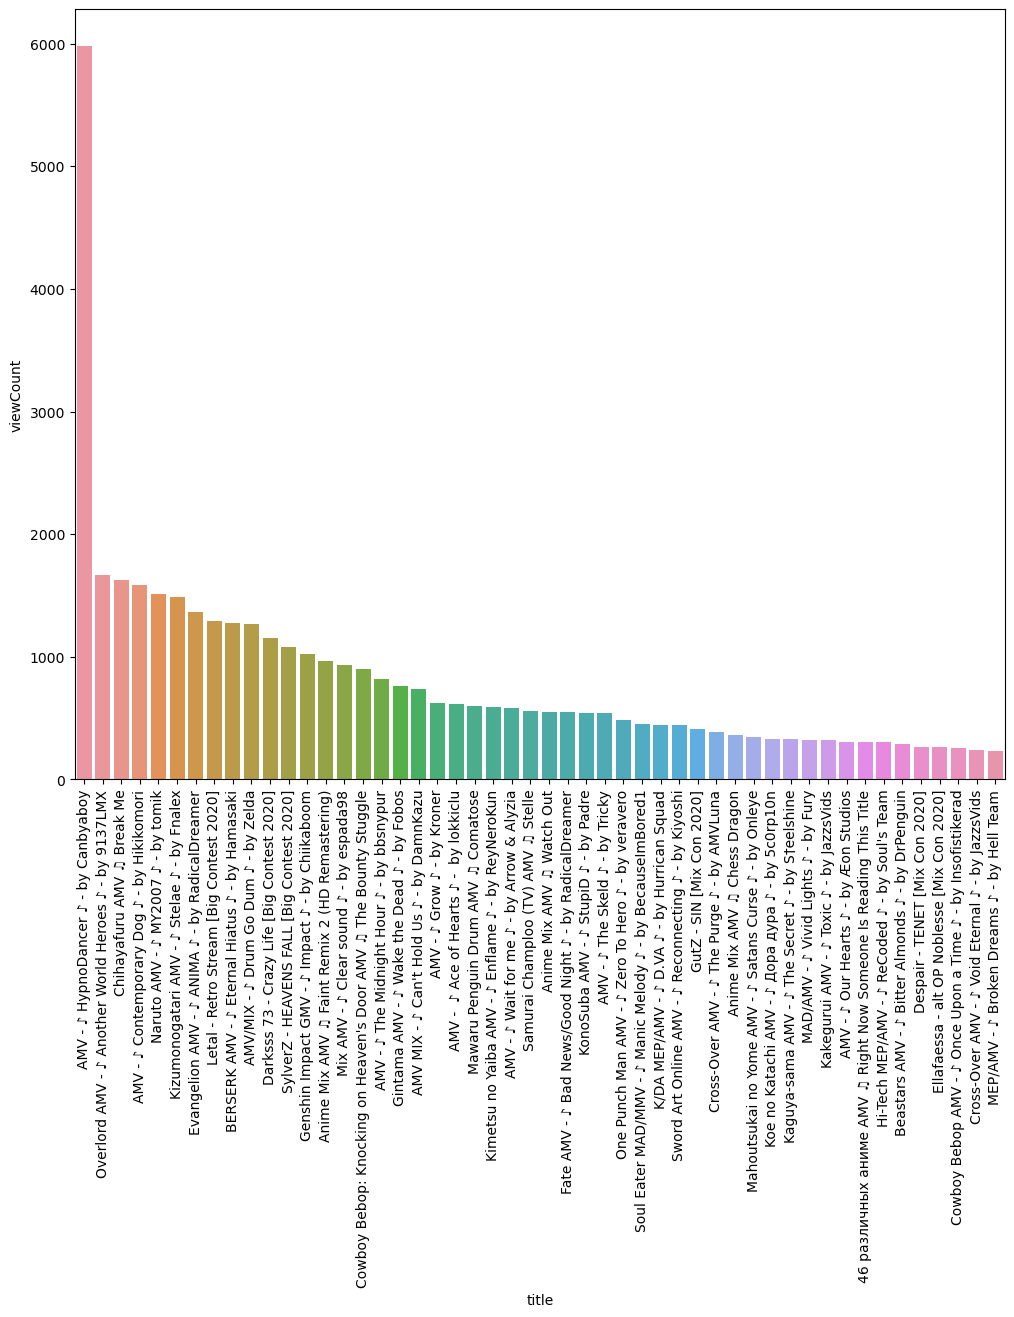

In [112]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(data = ORG_vid_info.sort_values('viewCount', ascending=False), x = 'title', y = 'viewCount')

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + "K"))

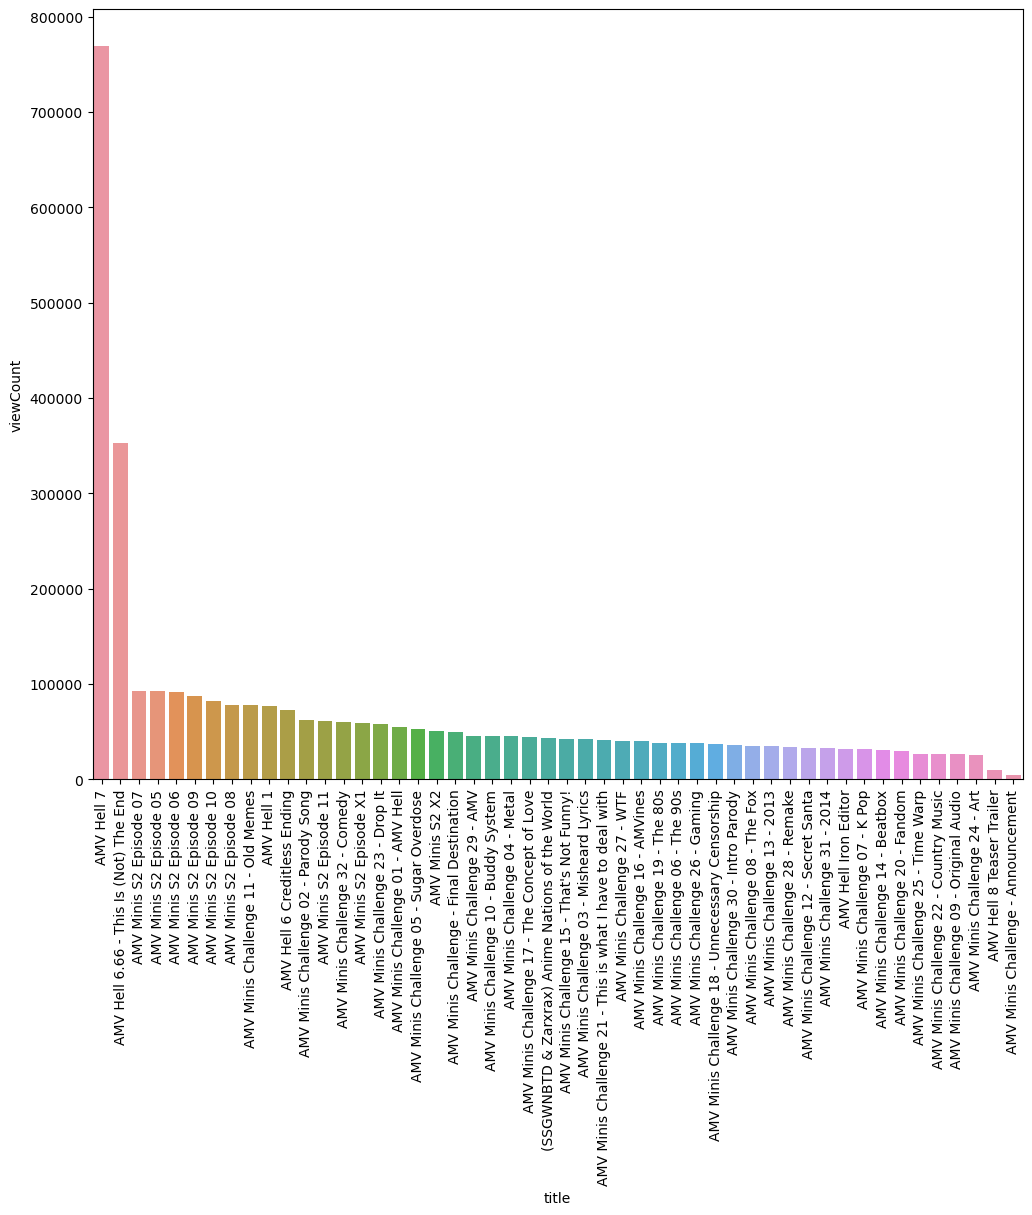

In [113]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(data = HELL_vid_info.sort_values('viewCount', ascending=False), x = 'title', y = 'viewCount')

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

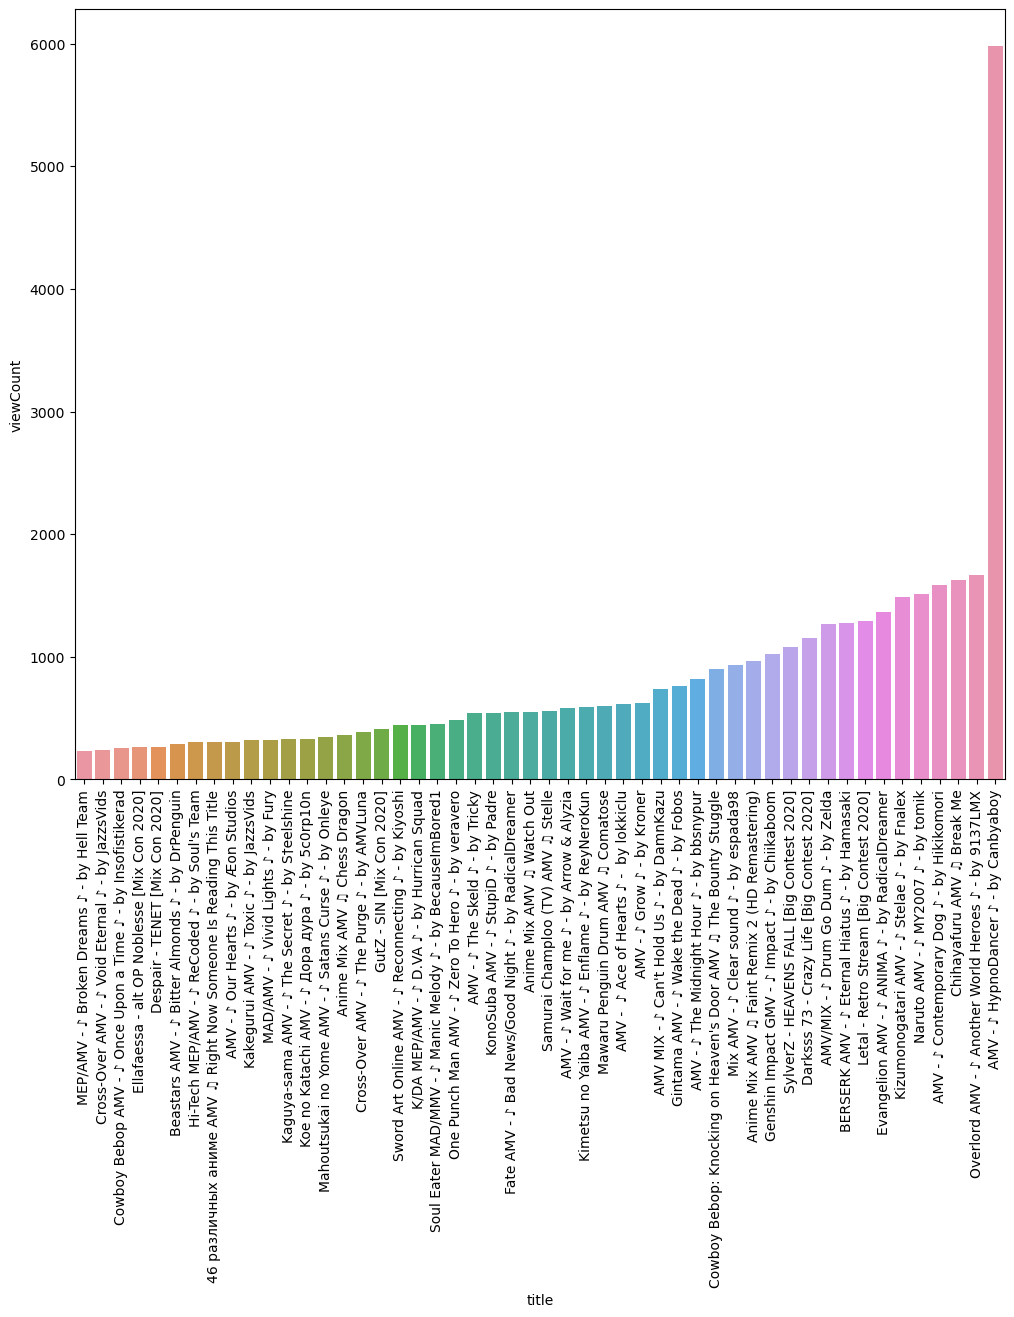

In [114]:
plt.figure(figsize=(12, 10))
ax = sns.barplot(data = ORG_vid_info.sort_values('viewCount', ascending=True), x = 'title', y = 'viewCount')

plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + "K"))

/Users/dumoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


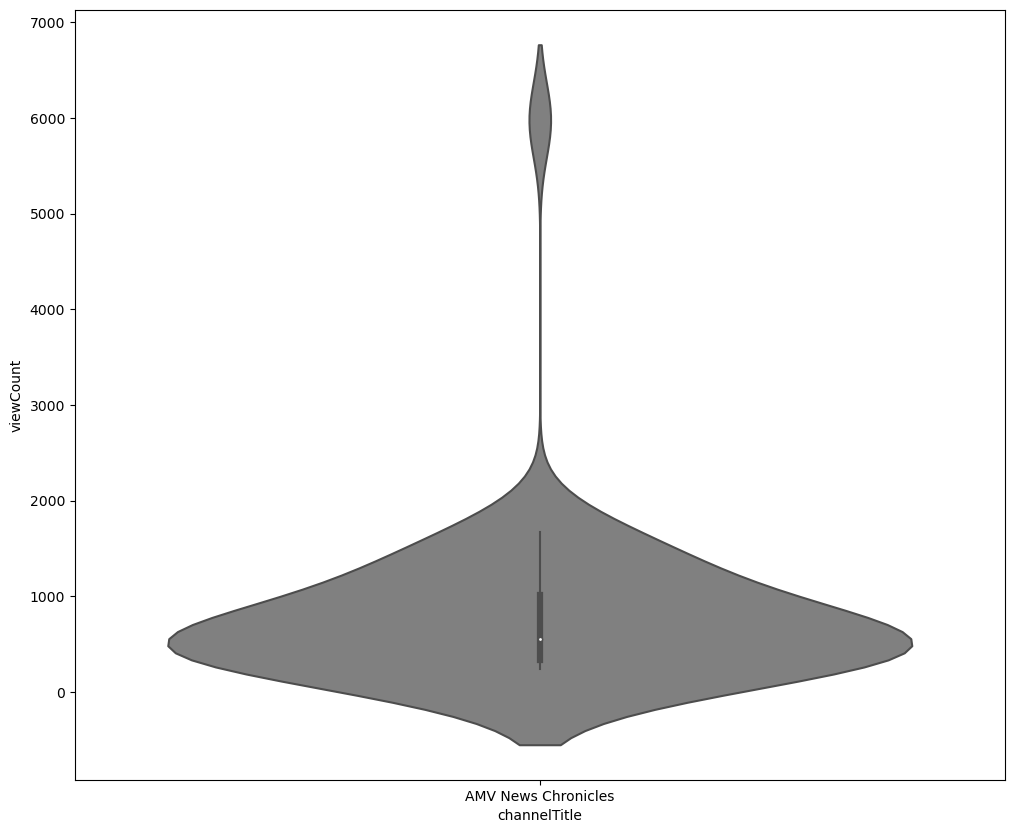

In [118]:
plt.figure(figsize=(12, 10))
sns.violinplot(ORG_vid_info['channelTitle'], ORG_vid_info['viewCount'],
               color='gray');

/Users/dumoura/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


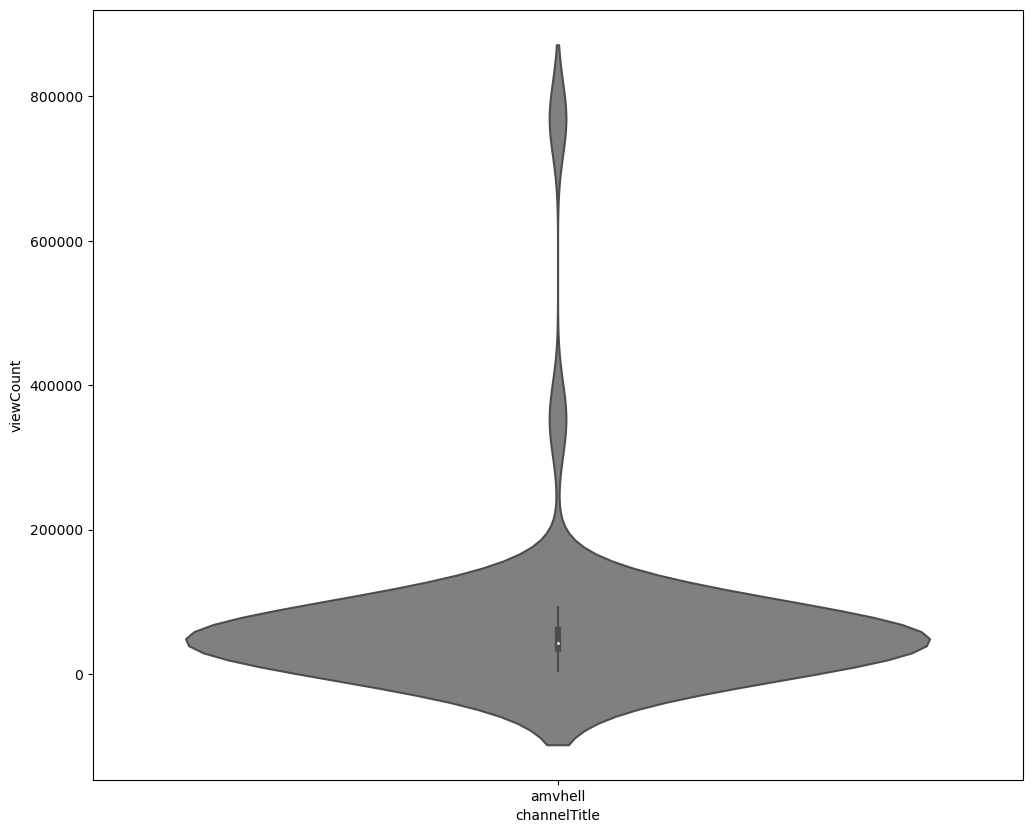

In [120]:
plt.figure(figsize=(12, 10))
sns.violinplot(HELL_vid_info['channelTitle'], HELL_vid_info['viewCount'],
               color='gray');

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

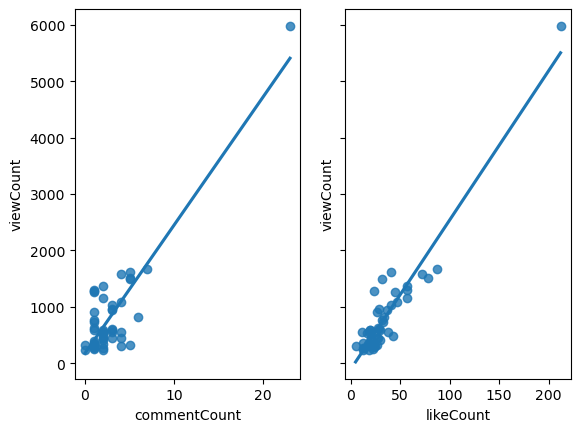

In [121]:
fig, ax = plt.subplots(1,2, sharey=True)

sns.regplot(data = ORG_vid_info,
                x = 'commentCount',
                y = 'viewCount',
                ci = False,
                ax = ax[0])

sns.regplot(data = ORG_vid_info,
               x = 'likeCount',
               y = 'viewCount',
               ci = False,
               ax = ax[1])



<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

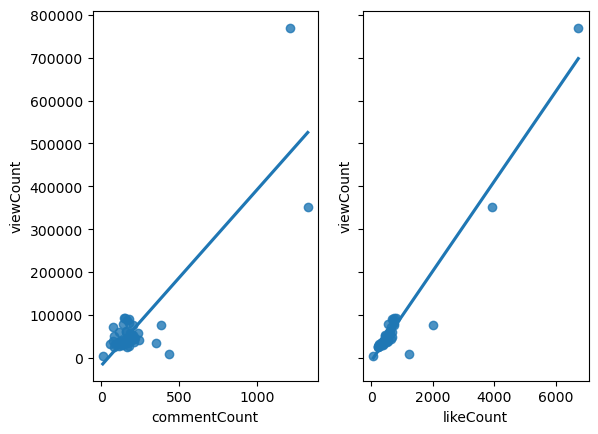

In [122]:
fig, ax = plt.subplots(1,2, sharey=True)

sns.regplot(data = HELL_vid_info,
                x = 'commentCount',
                y = 'viewCount',
                ci = False,
                ax = ax[0])

sns.regplot(data =  HELL_vid_info,
               x = 'likeCount',
               y = 'viewCount',
               ci = False,
               ax = ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

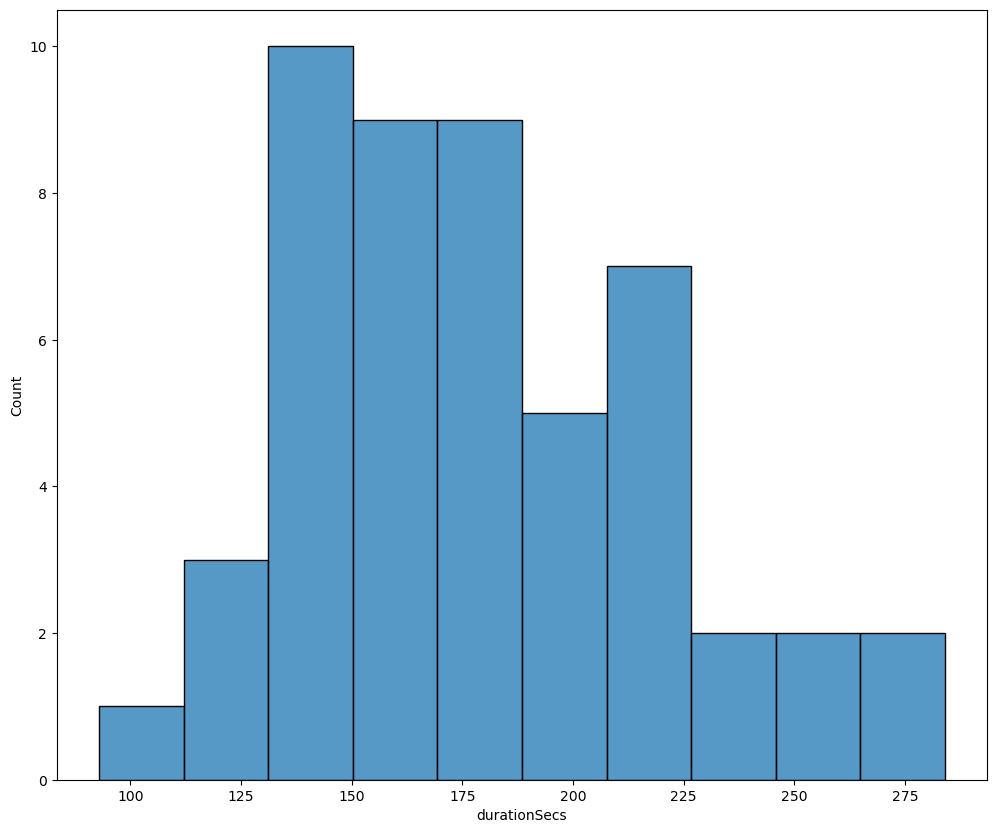

In [124]:
plt.figure(figsize=(12,10))
sns.histplot(data= ORG_vid_info, x="durationSecs", bins=10)

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

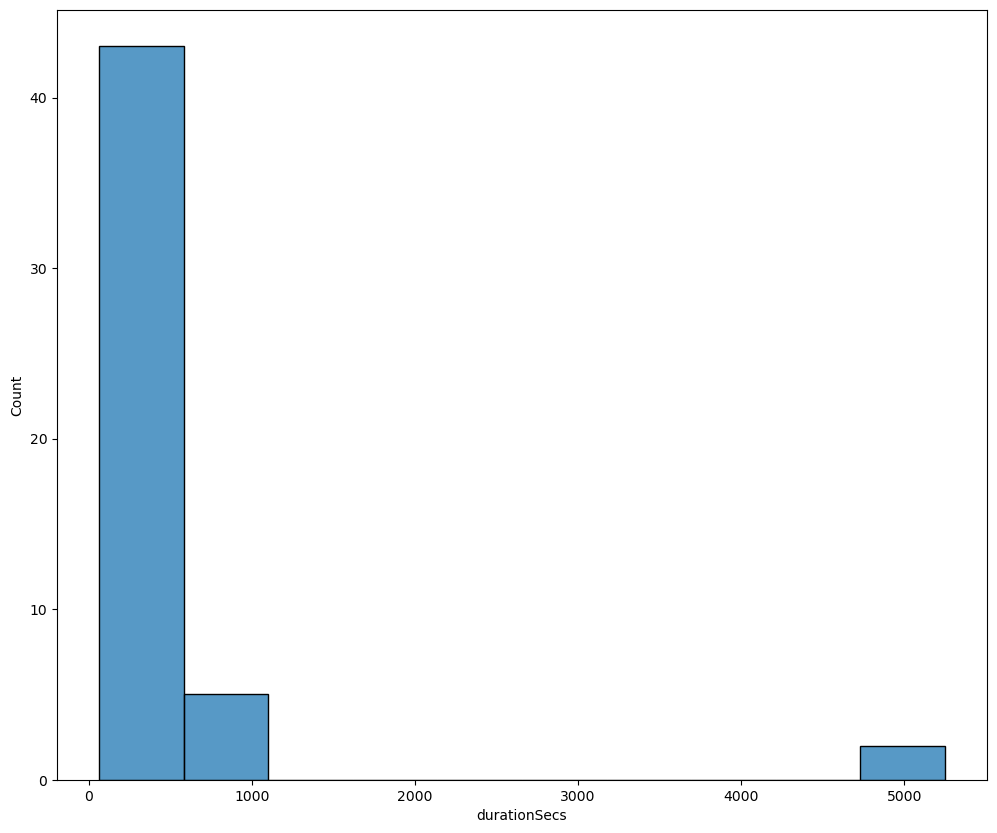

In [125]:
plt.figure(figsize=(12,10))
sns.histplot(data= HELL_vid_info, x="durationSecs", bins=10)

In [128]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dumoura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dumoura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [129]:
stop_words = set(stopwords.words('english'))

In [138]:
ORG_vid_info['title_no_stopwords'] = ORG_vid_info['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in ORG_vid_info['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

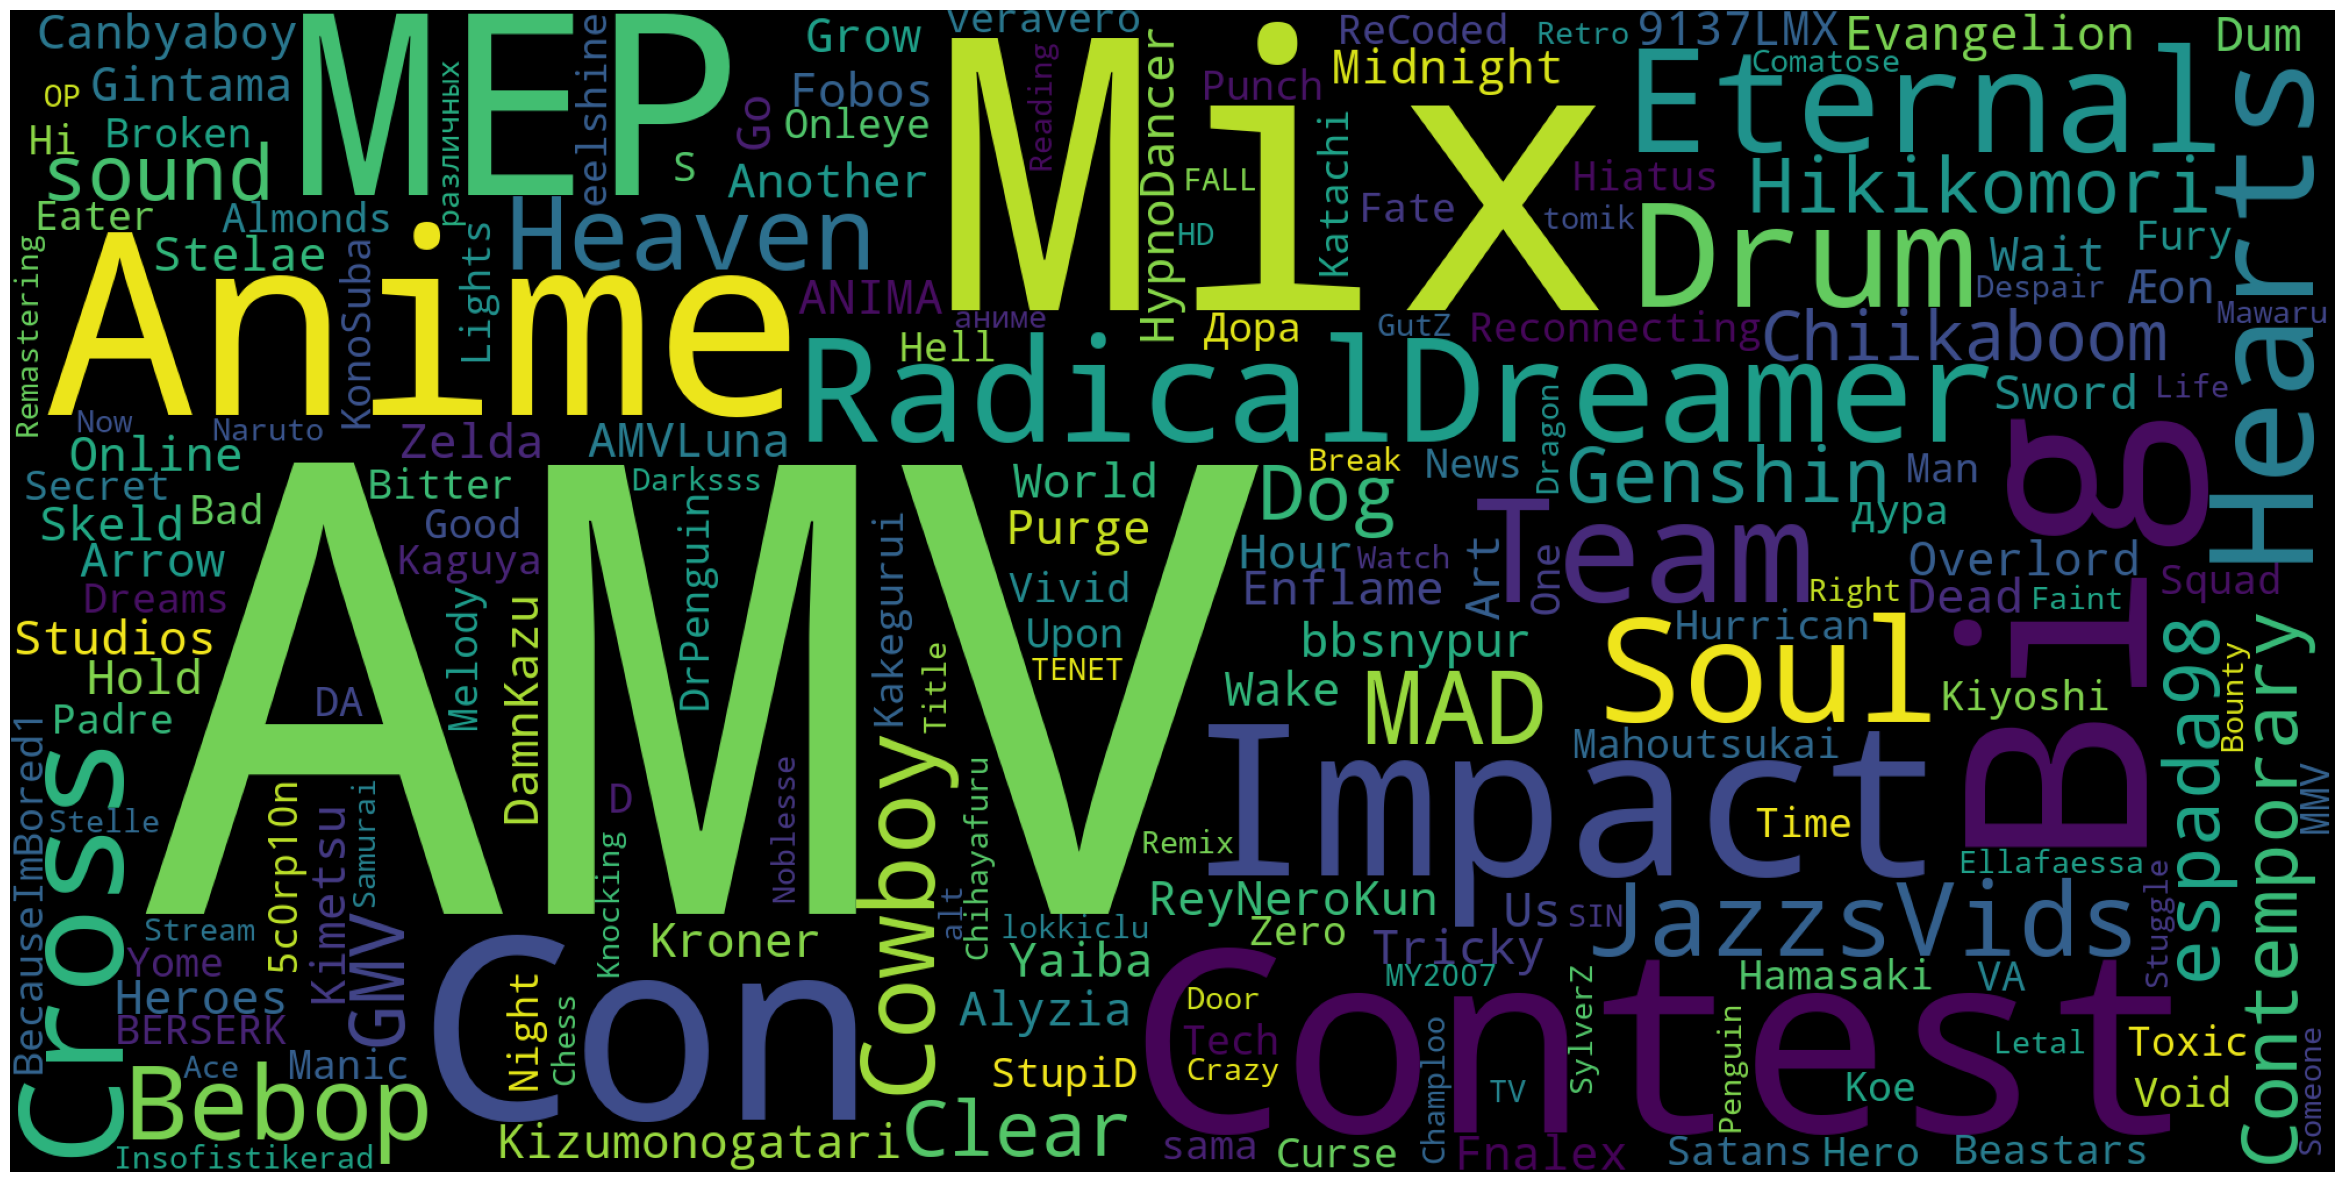

In [139]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

In [140]:
ORG_vid_info['publishDayName']

0      Saturday
1        Friday
2     Wednesday
3        Sunday
4        Friday
5      Saturday
6      Saturday
7     Wednesday
8        Friday
9        Friday
10       Monday
11       Friday
12    Wednesday
13     Saturday
14     Thursday
15       Friday
16      Tuesday
17     Saturday
18     Saturday
19      Tuesday
20       Friday
21       Monday
22      Tuesday
23       Sunday
24       Friday
25     Thursday
26      Tuesday
27       Sunday
28     Thursday
29    Wednesday
30       Monday
31       Sunday
32     Saturday
33       Friday
34     Thursday
35    Wednesday
36      Tuesday
37       Monday
38       Monday
39       Monday
40       Monday
41       Sunday
42       Monday
43       Sunday
44     Saturday
45       Friday
46    Wednesday
47      Tuesday
48       Monday
49       Sunday
Name: publishDayName, dtype: object

In [141]:
day_df = pd.DataFrame(ORG_vid_info['publishDayName'].value_counts())

In [142]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

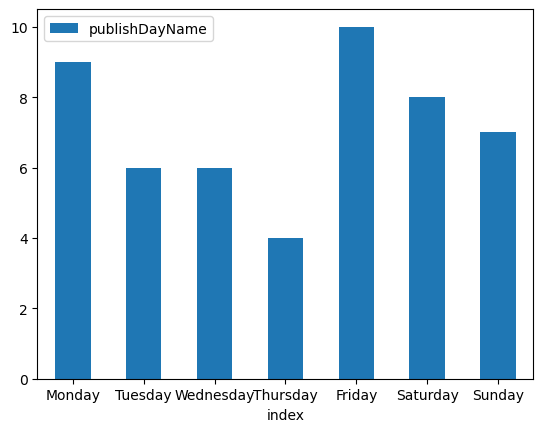

In [143]:
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0);

In [97]:
#df_vids_comments